<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Shakespeare_LM_v2_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WARNING**:

This colab's usage of Transformer library is likely to be wrong, and the prediction result is very bad.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
USE_GPU = True

BLOCK_SIZE = 64 # Context length: how many chars do we take to predict the next one?

# Setup GPU

In [ ]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


In [ ]:
g_cpu = torch.Generator(device='cpu').manual_seed(2147483647) # for reproducibility
g_device = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

# Util Functions

In [ ]:
def _total_params(layers):
  """ Get the total parameter number.

  Args:
    layers: the list of layers of the model

  Returns:
    Number of total parameters
  """
  total_params = 0
  for l in layers:
    for p in l.parameters():
      total_params += p.data.nelement()
  return total_params

In [ ]:
def _sample_one_batch(X, Y, batch_size, generator):
  """Sample from ds and generate a batch.

  Args:
    X: features of ds
    Y: labels of ds
    batch_size: batch size
    generator: a pseudorandom number generator for sampling
  Returns:
    Xb: batched features
    Yb: batched labels
  """
  ix = torch.randint(0, X.shape[0], (batch_size, ), generator=generator).to(device)
  # print(f'{ix.device=}')
  Xb, Yb = X[ix], Y[ix]
  return Xb, Yb

In [ ]:
def _calculate_loss(Xb, Yb, layers):
  """ Calculate loss.

  Args:
    Xb: the feature batch
    Yb: the label batch
    layers: the layers of the model

  Returns:
    loss: the calculated loss
  """
  emb = C[Xb]
  # print(f'{emb.device=}')
  x = emb.view(emb.shape[0], -1)
  # print(f'{x.device=}')
  for l in layers:
    x = l(x)
    # print(f'{x.device=}')
  loss = F.cross_entropy(x, Yb)
  # print(f'{loss.device=}')
  return loss

# Load data

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# read in all the words
text = open('input.txt', 'r').read()

text[:800]

--2023-10-01 17:43:25--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.4’

input.txt.4         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-10-01 17:43:26 (20.1 MB/s) - ‘input.txt.4’ saved [1115394/1115394]



"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to p"

In [ ]:
print(f'total char # = {len(text)}')

total char # = 1115394


# Build vocabulary

In [ ]:
chars = sorted(list(set(''.join(text))))

stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['[MASK]'] = 0
itos = {i:c for c,i in stoi.items()}

assert len(stoi) == len(itos)

vocab_size = len(stoi)

EXPECTED_VOCAB_SIZE = 66
assert vocab_size == EXPECTED_VOCAB_SIZE, f"expected vocab size = {EXPECTED_VOCAB_SIZE}, got {vocab_size}"

In [ ]:
# str ---> list of integer
encode = lambda str: [stoi[s] for s in str]

# list of integer ---> str
decode = lambda l: ''.join(itos[i] for i in l)

_test_str = "adb dfd \n"
assert _test_str == decode(encode(_test_str))

# Create DS

In [ ]:
# Split train and dev

encoded = encode(text)

n1 = int(0.9 * len(encoded))
data_tr = torch.tensor(encoded[:n1])
data_dev = torch.tensor(encoded[n1:])

print(f'{data_tr.shape=}, {data_dev.shape=}')

data_tr.shape=torch.Size([1003854]), data_dev.shape=torch.Size([111540])


In [ ]:
def encoded_char_seq_to_examples(X):
  """ Convert an encoded char seq to examples.

  Args:
    X: 1-rank tensor containing the encoded char seq

  Returns:
    1st: A tensor containing the features of the examples. It has size [B, N], where B is the number of examples, N is the number of features for each example.
    2st: A tensor containing the label of the exampels. It has size [B], where B is the number of examples.
  """
  xx = []
  yy = []

  context = [0] * BLOCK_SIZE
  for i in range(X.shape[0]):
    xx.append(torch.tensor(context))
    yy.append(X[i])
    context = context[1:] + [X[i].item()]

  return torch.stack(xx), torch.stack(yy)


In [ ]:
from numpy import block
def get_batch(data, batch_size, block_size):
  # 1. Get batch_size of char sequences, each has block_size+1 char
  ix = torch.randint(0, len(data) - block_size, (batch_size, ), generator=g_cpu)
  X = torch.stack([data[i:i+1+block_size] for i in ix])

  # 2. Expand each char sequences to block_size examples
  expanded_X = []
  expanded_Y = []
  for i in range(X.shape[0]):
    xx, yy = encoded_char_seq_to_examples(X[i])
    # print(f'{xx.shape=}, {yy.shape=}')
    expanded_X.append(xx)
    expanded_Y.append(yy)

  stacked_X, stacked_Y = torch.stack(expanded_X), torch.stack(expanded_Y)
  return stacked_X.view(-1, stacked_X.shape[-1]).to(device), stacked_Y.view(-1).to(device)

X, Y = get_batch(data_tr, batch_size=32, block_size=BLOCK_SIZE)

In [ ]:
X.shape, Y.shape

(torch.Size([2080, 64]), torch.Size([2080]))

In [ ]:
i = 0
for ttt, uuu in zip(X,Y):
  print(f'{decode(ttt.view(-1).tolist())}--->{decode([uuu.item()])}')
  if i > 100:
    break
  i += 1


# Modeling

In [ ]:
n_embd = 4 # the dimensionality of the character embedding vectors
N_HIDDEN = n_embd * BLOCK_SIZE * 2 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

## Model class

In [ ]:
import math

class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # print(f'{x.shape=}, {self.pe.shape=}, {self.pe[:x.size(0)].shape=}')
        x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [ ]:
class Net(torch.nn.Module):
  def __init__(self,
               vocab_size,  # size of vocabulary
               d_embd,  # dim of the token's embedding
               block_size,
               n_head: int, # number of heads in `nn.MultiheadAttention`
               n_layers: int, # number of `nn.TransformerEncoderLayer` in `nn.TransformerEncoder`
               d_hidden: int, # dim of the ffn model in `nn.TransformerEncoder`
               dropout: float = 0.5,
               generator=None):
    super().__init__()
    self.model_type = 'Transformer'

    self.pos_encoder = PositionalEncoding(d_embd * block_size, dropout)
    # self.pos_encoder = PositionalEncoding(block_size, dropout)

    encoder_layers = torch.nn.TransformerEncoderLayer(d_embd * block_size, n_head, d_hidden, dropout)
    self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, n_layers)

    self.embd = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_embd)
    self.d_embd = d_embd
    self.block_size = block_size

    self.linear_logits = torch.nn.Linear(d_embd * block_size, vocab_size, bias=True)

    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.embd.weight.data.uniform_(-initrange, initrange)
    self.linear_logits.bias.data.zero_()
    self.linear_logits.weight.data.uniform_(-initrange, initrange)

  def forward(self, x):
    xemb = self.embd(x) * math.sqrt(self.d_embd * self.block_size)
    xemb = xemb.view(xemb.shape[0], -1)
    # print(f'{xemb.shape=}, {x.shape=}')
    xps = self.pos_encoder(xemb)
    # print(f'{xemb.shape=}, {xps.shape=}')

    # y = xemb.view(xemb.shape[0], -1)
    x = self.transformer_encoder(xps)
    x = self.linear_logits(x)
    return x

net = Net(vocab_size=vocab_size,
          d_embd=n_embd,
          block_size=BLOCK_SIZE,
          n_head=4,
          n_layers=4,
          d_hidden=N_HIDDEN).to(device)

In [ ]:
_total_params = 0

for p in net.parameters():
  _total_params += p.nelement()
  # print(f'{p.data.shape=}')

print(f'Total params = {_total_params}')

Total params = 2125642


## Define loss fn and optimizer

In [ ]:
import torch.optim as optim

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train

In [ ]:
max_steps = 700000
batch_size = 4
lossi = []
lossi_dev = []
ud = []
log_interval = 200

running_loss = 0.0
running_loss_dev = 0.0
running_loss_steps = 0

for i in range(max_steps):

  # Forward
  Xb, Yb = get_batch(data_tr, batch_size, BLOCK_SIZE)
  optimizer.zero_grad()
  outputs = net(Xb)

  # Loss
  # print(f'{outputs.shape=}, {Yb.shape=}')
  loss = loss_fn(outputs, Yb)
  running_loss += loss.item()
  running_loss_steps += 1

  # Eval dev DS
  Xb_dev, Yb_dev = get_batch(data_dev, batch_size, BLOCK_SIZE)
  outputs_dev = net(Xb_dev)
  loss_dev = loss_fn(outputs_dev, Yb_dev)
  running_loss_dev += loss_dev.item()

  # Update
  loss.backward()
  optimizer.step()

  # Track status
  if i % log_interval == 0:
    print(f'{i}/{max_steps}: training loss={running_loss/running_loss_steps:.4f}, dev loss={running_loss_dev/running_loss_steps:.4f}')
    running_loss = 0.0
    running_loss_dev = 0.0
    running_loss_steps = 0

  lossi.append(loss.log10().item())
  lossi_dev.append(loss_dev.log10().item())

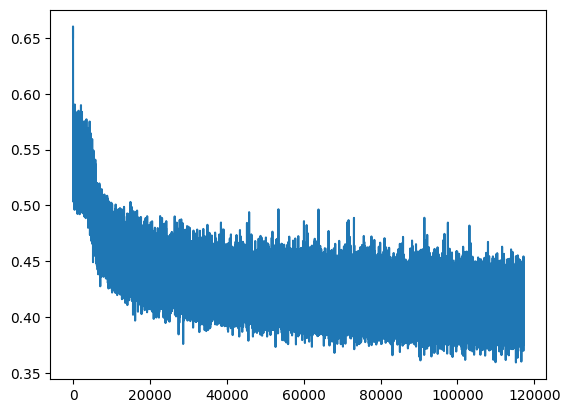

In [ ]:
plt.plot(lossi)

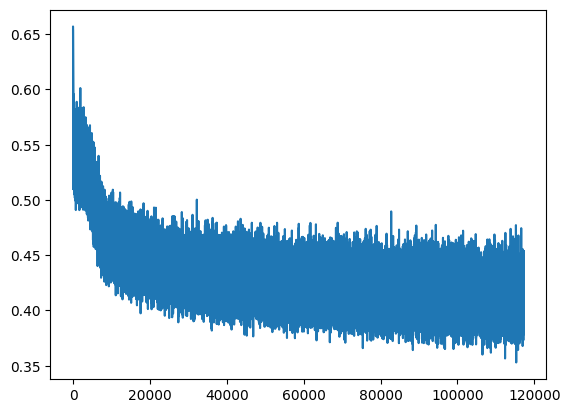

In [ ]:
plt.plot(lossi_dev)

In [ ]:
torch.cuda.empty_cache()

# Sample the model

In [ ]:
g_gpu = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility

i = 0

iys = []
context = [0] * BLOCK_SIZE
while True:
  x = torch.tensor([context]).to(device)
  logits = net(x)
  prob = F.softmax(logits, dim=1)
  iy = torch.multinomial(prob, num_samples=1, replacement=True, generator=g_gpu)

  if i > 1000:
    break

  iys.append(iy.item())
  context = context[1:] + [iy.item()]

  i += 1

print(decode(iys))


H

nUCU
NTR hLRo ,
S C? Mouro o seee!KB wttln m bs?K
AUS, desn ao moiui,, manolTrwyter'rsl, n sneOtour iG,WtonytA tou,,;

G PlHL'Al lReadtGtro tfonaas:z


IUoO:

, R en tR:
Ae c:Qhas, oxmylp; t:UCCty KJo,,ev,,
HtrI,rgmlseyJt: 
E,:

L y I,eWl ald. rLdeey
nIo:ElGs! A I UI f:,H:.h
bxy? T,  hoo:, A: IetTy!
aeetsas :''m!
Iluehm'
que
Us GDatuoe! t
GooI Ya:
tinI,


RDILLS
F
A
R obesus,,Lfh'iIoc thtee:ah:

: Hy e tBoUt so aolhsFcs,s'dl d'yud.
AvAyf
,


MORyLIOB:?:
t,,t.?n
OS ,IGedNaot: nfono.:!.Ya,tia,'::
: yolplrSKla f I :'rt d ly ar'ey, tyr ooT,:
lGCU
Mfl:
WieB. 
vE

U.

HNb:
:s. KEGo.
OnlrI, 

xylbnemR  W Tle,
Mh?
oR,GYSY.
ThIom.
o
AedFoy,nnoni:s
' o idnnSM yldeNsf
 

IBASLAl
W ,KZh: ZB

YII
RUO  E nLN: fRp dl,B

LIZGnNA,b,
CPyON ae?auhiny Yiromfaio tsdo b  pea aowedlOtwass 



LDR NILHL: Cteloths?rLH C,.
dsr
NI
KNRulwU,
sGy,et: Ioat'owtahe s O t ,lsnew pom s'ulLAwndt:

iie w TosLt:ol'eeuathy'de'ndiAly aed,:
:e;:!C
YN
Roure:,,yd:   f,S?:litysaeau anedyateuty,n! siss:
 WCire: S toarsd $, He